## Brief description of the problem and data

This project is about analyzing a large number of tweets (10,000) and determining based on the context if the tweet is about a real disaster ocurring or not. The problem will be addressed by training a recurrent neural network (rnn), comparing different architectures and applying the best fitted model.

* Objective: The score is evaluated as F1. 

$$ F1=2*\frac{precision * recall}{precision + recall} $$

$$ precision = \frac{TP}{TP+FP} $$

$$ recall = \frac{TP}{TP+FN} $$
    
    
* Problem Type: Binary Classification
* Dataset: A curated list of 10,000 tweets hand classified. Other than the label and tweet text, it has some features like location and keyword.

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

In [1]:
import numpy as np
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2024-06-16 00:36:36.731113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 00:36:36.731813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 00:36:36.944276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The first step is getting rid of duplicated tweets, the keyword and location features are not guranteed in every tweet, so they were removed to reduce noise.

In [5]:
df = df.drop_duplicates("text")
df = df.drop(["keyword","location"], axis=1)

The next step is to generate training and validation splits to explore the data further.

In [6]:
train_df, val_df = train_test_split(df, test_size=.2, random_state=28)

In [7]:
train_df.target.value_counts()

target
0    3449
1    2553
Name: count, dtype: int64

Tweets have all types of special characters and symbols that don't necessary add to the discussion around emergency and disasters, so they were also removed.

In [8]:
def clean_text(text):
    # Remove non-letter characters and convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = text.lower() # turn into lowercase
    
    return text
train_df["text"] = train_df["text"].apply(clean_text)

To solve the word embedding processing, the TF-IDF method is implemented:

TF calculates the term frequency of each word in each article. 

IDF calculates the frequency of each word across all the articles. 

TF-IDF together calculate the importance of each word and assign weights to each word according to the frequency. 

The output after applying the TF-IDF function is a matrix with documents and words, the values are the assigned weights.

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=30, stop_words="english")
X = tfidf_vectorizer.fit_transform(df['text']).toarray()
feature_names = tfidf_vectorizer.get_feature_names_out()
train_tf_idf = pd.DataFrame(X, columns=feature_names)
train_tf_idf["target"] = train_df["target"]

In [10]:
tf_idf_mean = train_tf_idf.groupby("target").agg("mean").reset_index().T.drop(["target", "http", "https"], axis=0)
tf_idf_mean.columns = ["No Disaster", "Disaster"]

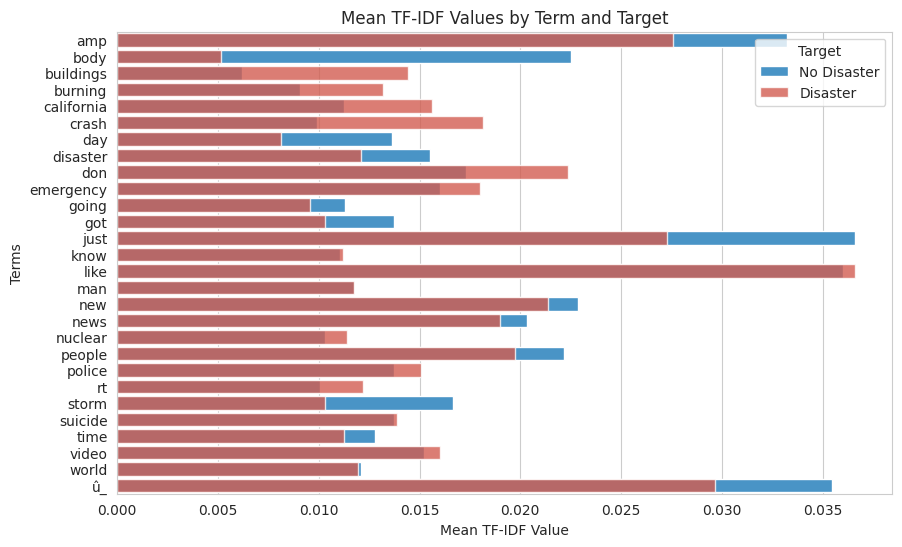

In [11]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
terms = tf_idf_mean.index
y = np.arange(len(terms))  # the label locations

# Create custom colors
color_for_0 = '#3498db'  # Blue color
color_for_1 = '#e74c3c'  # Red color

# Creating the horizontal bar chart
sns.barplot(data=tf_idf_mean, x='No Disaster', y=terms, color=color_for_0, label='No Disaster', ax=ax)
sns.barplot(data=tf_idf_mean, x='Disaster', y=terms, color=color_for_1, alpha=.8, label='Disaster', ax=ax)

# Adding labels, title and custom y-axis tick labels, etc.
ax.set_xlabel('Mean TF-IDF Value')
ax.set_ylabel('Terms')
ax.set_title('Mean TF-IDF Values by Term and Target')
ax.legend(title='Target')

# Show the plot
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [13]:
# Example data


# Tokenization and padding
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_df.text)
sequences = tokenizer.texts_to_sequences(train_df.text)
padded_sequences = pad_sequences(sequences, maxlen=10)


In [14]:
from collections import Counter

# Example data
texts = ["This is a positive example", "This is a negative example"]


index_word = {i: w for w, i in tokenizer.word_index.items()}

# Detokenize sequences and count word frequencies
detokenized_texts = []
for sequence in sequences:
    words = [index_word.get(idx, '') for idx in sequence]
    detokenized_texts.extend(words)

word_counts = Counter(detokenized_texts)

# Most common word
most_common_word, most_common_count = word_counts.most_common(1)[0]

print(f"The most common word is '{most_common_word}' appearing {most_common_count} times.")


The most common word is 'the' appearing 2570 times.


In [15]:
for index, (key, value) in enumerate(index_word.items()):
    if index < 5:
        print(f"{key}: {value}")
for index, (key, value) in enumerate(word_counts.items()):
    if index < 5:
        print(f"{key}: {value}")

1: the
2: a
3: in
4: to
5: of
love: 80
how: 147
i: 1084
dont: 156
get: 174


In [16]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_pred_binary = K.round(y_pred)  # y_pred_binary is already float32 from rounding

    tp = K.sum(y_true * y_pred_binary, axis=0)
    fp = K.sum((1 - y_true) * y_pred_binary, axis=0)
    fn = K.sum(y_true * (1 - y_pred_binary), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Handle NaNs if precision and recall are zero
    return K.mean(f1)  # Return average F1 score across batches



In [17]:
# Building the model
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=32, input_length=10))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with custom F1 score metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score])

# Train the model
model.fit(padded_sequences, train_df.target.astype("int32"), epochs=10)


# Predict
predictions = model.predict(padded_sequences)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - f1_score: 0.2950 - loss: 0.6290
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.7569 - loss: 0.4130
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.7818 - loss: 0.3866
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.7942 - loss: 0.3747
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.7995 - loss: 0.3559
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.8235 - loss: 0.3312
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.8203 - loss: 0.3205
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.8115 - loss: 0.3207
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.8430 - loss: 0.2956
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.8521 - loss: 0.2752
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [18]:
sequences = tokenizer.texts_to_sequences(val_df.text)
padded_sequences = pad_sequences(sequences, maxlen=10)
predictions = model.predict(padded_sequences)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [19]:
val_pred = pd.DataFrame(predictions, columns=["pred"]).reset_index()
val_pred['py'] = (val_pred['pred'] > .5)*1
val_pred["target"] = val_df.reset_index()['target']

In [20]:
sum(val_pred.py == val_pred.target)/1501

0.7295136575616256

## Model Architecture

## Results and Analysis

## Conclusion